## Trial Run: Predicting with Keras 




### Load the required libraries

In [3]:
import tensorflow as tf
# import tensorflowvisu
import math
import pandas as pd
import numpy as np
import glob
from sklearn import preprocessing
# Set charts to view inline
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
print("Tensorflow version " + tf.__version__)

Tensorflow version 1.1.0


In [4]:
df = pd.read_csv("crypto_sent.csv")

In [5]:
df.head()

,Unnamed: 0,id,created_at,text,sentiment,score
0,0,965368977881886720,2018-02-18 23:34:34,RT @Jensen: That blows. GG Fox!,positive,0.4981
1,1,965367147990892544,2018-02-18 23:27:18,gg. Tough loss. Fuel for practice https://t....,neutral,-0.1531
2,2,965349444664180741,2018-02-18 22:16:57,RT @lolesports: Who's the #1 in North America?...,neutral,0.0000
3,3,965348773323919360,2018-02-18 22:14:17,RT @Cloud9: Today #C9LoL battles @echofoxgg fo...,negative,-0.3818
4,4,965042976794714112,2018-02-18 01:59:09,@cryptograffiti can you send me a DM so i can ...,neutral,0.0000


In [6]:
# id and sentiment are categoricals
df['id'] = df['id'].astype('category')
df['sentiment'] = df['sentiment'].astype('category')
df['created_at'] = pd.to_datetime(df['created_at'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64378 entries, 0 to 64377
Data columns (total 6 columns):
Unnamed: 0    64378 non-null int64
id            64378 non-null category
created_at    64378 non-null datetime64[ns]
text          64378 non-null object
sentiment     64378 non-null category
score         64378 non-null float64
dtypes: category(2), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.3+ MB


In [8]:
# make a time series of mean score per day
ts = df.groupby(pd.Grouper(key='created_at', freq='D')).mean()

In [9]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2996 entries, 2009-12-08 to 2018-02-19
Freq: D
Data columns (total 2 columns):
Unnamed: 0    2371 non-null float64
score         2371 non-null float64
dtypes: float64(2)
memory usage: 70.2 KB


In [10]:
ts.head()

,Unnamed: 0,score
created_at,,
2009-12-08,3200.5,0.214733
2009-12-09,3197.0,0.822500
2009-12-10,3196.0,-0.743000
2009-12-11,NaN,NaN
2009-12-12,NaN,NaN


In [11]:
# get the bitcoin prices
bc = pd.read_csv("bitcoinity_all.csv")

In [12]:
bc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 8 columns):
date       731 non-null object
diff       731 non-null float64
trans      731 non-null int64
volatil    731 non-null float64
bidask     731 non-null float64
price      731 non-null float64
volume     731 non-null float64
transpm    731 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 45.8+ KB


In [13]:
bc.head()

,date,diff,trans,volatil,bidask,price,volume,transpm
0,2/25/16 0:00:00,1.634920e+11,216290,0.877869,0.395403,422.833398,2.414980e+07,295.393889
1,2/26/16 0:00:00,1.634920e+11,203635,0.564052,0.359820,423.847443,3.032645e+07,270.019722
2,2/27/16 0:00:00,1.634920e+11,182177,0.471312,0.397194,431.913038,1.763800e+08,227.732431
3,2/28/16 0:00:00,1.634920e+11,233436,0.668662,0.411491,428.947530,1.354377e+08,259.078542
4,2/29/16 0:00:00,1.634920e+11,265320,0.936643,0.476494,436.160354,4.114757e+08,377.598750


In [14]:
# create a new column that we'll make the index so we can merge dataframes
bc['newdate'] = pd.DatetimeIndex(bc.date).normalize()

In [15]:
bc.head()

,date,diff,trans,volatil,bidask,price,volume,transpm,newdate
0,2/25/16 0:00:00,1.634920e+11,216290,0.877869,0.395403,422.833398,2.414980e+07,295.393889,2016-02-25
1,2/26/16 0:00:00,1.634920e+11,203635,0.564052,0.359820,423.847443,3.032645e+07,270.019722,2016-02-26
2,2/27/16 0:00:00,1.634920e+11,182177,0.471312,0.397194,431.913038,1.763800e+08,227.732431,2016-02-27
3,2/28/16 0:00:00,1.634920e+11,233436,0.668662,0.411491,428.947530,1.354377e+08,259.078542,2016-02-28
4,2/29/16 0:00:00,1.634920e+11,265320,0.936643,0.476494,436.160354,4.114757e+08,377.598750,2016-02-29


In [16]:
# make the new column the index for bitcoin prices
bc.set_index('newdate', inplace=True)

In [17]:
bc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2016-02-25 to 2018-02-24
Data columns (total 8 columns):
date       731 non-null object
diff       731 non-null float64
trans      731 non-null int64
volatil    731 non-null float64
bidask     731 non-null float64
price      731 non-null float64
volume     731 non-null float64
transpm    731 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 51.4+ KB


In [18]:
# check to be sure formats match
ts.head()

,Unnamed: 0,score
created_at,,
2009-12-08,3200.5,0.214733
2009-12-09,3197.0,0.822500
2009-12-10,3196.0,-0.743000
2009-12-11,NaN,NaN
2009-12-12,NaN,NaN


In [19]:
# this is an inner join by default
newdf = pd.merge(bc, ts, left_index=True, right_index=True)

In [20]:
# we get 726 rows for our 2 years of data
newdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 726 entries, 2016-02-25 to 2018-02-19
Data columns (total 10 columns):
date          726 non-null object
diff          726 non-null float64
trans         726 non-null int64
volatil       726 non-null float64
bidask        726 non-null float64
price         726 non-null float64
volume        726 non-null float64
transpm       726 non-null float64
Unnamed: 0    725 non-null float64
score         725 non-null float64
dtypes: float64(8), int64(1), object(1)
memory usage: 62.4+ KB


In [21]:
newdf.head()

,date,diff,trans,volatil,bidask,price,volume,transpm,Unnamed: 0,score
2016-02-25,2/25/16 0:00:00,1.634920e+11,216290,0.877869,0.395403,422.833398,2.414980e+07,295.393889,1924.750000,0.063306
2016-02-26,2/26/16 0:00:00,1.634920e+11,203635,0.564052,0.359820,423.847443,3.032645e+07,270.019722,2220.666667,0.106433
2016-02-27,2/27/16 0:00:00,1.634920e+11,182177,0.471312,0.397194,431.913038,1.763800e+08,227.732431,2201.928571,0.056521
2016-02-28,2/28/16 0:00:00,1.634920e+11,233436,0.668662,0.411491,428.947530,1.354377e+08,259.078542,1931.333333,0.047878
2016-02-29,2/29/16 0:00:00,1.634920e+11,265320,0.936643,0.476494,436.160354,4.114757e+08,377.598750,2039.857143,0.139419


In [22]:
sum(pd.isnull(newdf['score']))

1

In [23]:
newdf.drop(newdf.columns[0],axis=1,inplace=True)

In [24]:
 newdf.isnull().any()

diff          False
trans         False
volatil       False
bidask        False
price         False
volume        False
transpm       False
Unnamed: 0     True
score          True
dtype: bool

In [25]:
newdf.drop(newdf.columns[7],axis=1,inplace=True)

In [26]:
newdf.head()

,diff,trans,volatil,bidask,price,volume,transpm,score
2016-02-25,1.634920e+11,216290,0.877869,0.395403,422.833398,2.414980e+07,295.393889,0.063306
2016-02-26,1.634920e+11,203635,0.564052,0.359820,423.847443,3.032645e+07,270.019722,0.106433
2016-02-27,1.634920e+11,182177,0.471312,0.397194,431.913038,1.763800e+08,227.732431,0.056521
2016-02-28,1.634920e+11,233436,0.668662,0.411491,428.947530,1.354377e+08,259.078542,0.047878
2016-02-29,1.634920e+11,265320,0.936643,0.476494,436.160354,4.114757e+08,377.598750,0.139419


In [27]:
newdf.isnull().any()

diff       False
trans      False
volatil    False
bidask     False
price      False
volume     False
transpm    False
score       True
dtype: bool

In [28]:
# need to get rid of that empty value in score; subbing in an average of two bracketing scores
# 0.187218571
newdf['score'].fillna(0.187218571, inplace=True)

In [29]:
# check it
newdf.loc[newdf['score'] == 0.187218571]

,diff,trans,volatil,bidask,price,volume,transpm,score
2016-05-08,1.786590e+11,189025,0.545233,0.506896,458.129573,13789951.05,179.829931,0.187219


In [30]:
newdf.to_csv('bitcoin_semscore.csv')

### Make Model II
Following Dashee at https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb

In [31]:
newdf.head()

,diff,trans,volatil,bidask,price,volume,transpm,score
2016-02-25,1.634920e+11,216290,0.877869,0.395403,422.833398,2.414980e+07,295.393889,0.063306
2016-02-26,1.634920e+11,203635,0.564052,0.359820,423.847443,3.032645e+07,270.019722,0.106433
2016-02-27,1.634920e+11,182177,0.471312,0.397194,431.913038,1.763800e+08,227.732431,0.056521
2016-02-28,1.634920e+11,233436,0.668662,0.411491,428.947530,1.354377e+08,259.078542,0.047878
2016-02-29,1.634920e+11,265320,0.936643,0.476494,436.160354,4.114757e+08,377.598750,0.139419


In [32]:
newdf['date'] = newdf.index

In [33]:
# to find columns for normalizing
# looks like diff, trans, volatil, transpm
newdf.describe()

,diff,trans,volatil,bidask,price,volume,transpm,score
count,7.260000e+02,726.000000,726.000000,726.000000,726.000000,7.260000e+02,726.000000,726.000000
mean,6.792756e+11,259070.951791,15.291298,0.566330,3045.026655,3.447175e+08,186.330182,0.124293
std,6.385959e+11,53047.562734,29.986647,0.300516,4045.445824,6.378220e+08,190.848958,0.083166
min,1.584270e+11,131875.000000,0.309804,0.122368,403.525223,7.692798e+06,6.829306,-0.356950
25%,2.173750e+11,221229.250000,1.067595,0.337099,632.014072,2.570754e+07,33.351367,0.078352
50%,4.407800e+11,250547.500000,2.859097,0.487276,1041.254032,6.832120e+07,121.583102,0.120952
75%,9.227250e+11,292452.750000,13.514089,0.761837,3902.613667,3.068351e+08,284.370278,0.165098
max,2.874670e+12,490644.000000,299.185609,1.575526,19389.505010,5.457602e+09,1060.248333,0.539618


In [34]:
# split date separates test, training rows
# window_len is the 10 day window to predict on
# norm_cols is the columns we'll normalize so keras doesn't choke
split_date = '2017-06-01'
window_len = 10
norm_cols = ['trans','volatil', 'transpm']

In [35]:
# create the training, test sets
# we don't need the date columns anymore
training_set, test_set = newdf[newdf['date']<split_date], newdf[newdf['date']>=split_date]
training_set = training_set.drop('date', 1)
test_set = test_set.drop('date', 1)

In [36]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 462 entries, 2016-02-25 to 2017-05-31
Data columns (total 8 columns):
diff       462 non-null float64
trans      462 non-null int64
volatil    462 non-null float64
bidask     462 non-null float64
price      462 non-null float64
volume     462 non-null float64
transpm    462 non-null float64
score      462 non-null float64
dtypes: float64(7), int64(1)
memory usage: 32.5 KB


In [37]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 2017-06-01 to 2018-02-19
Data columns (total 8 columns):
diff       264 non-null float64
trans      264 non-null int64
volatil    264 non-null float64
bidask     264 non-null float64
price      264 non-null float64
volume     264 non-null float64
transpm    264 non-null float64
score      264 non-null float64
dtypes: float64(7), int64(1)
memory usage: 18.6 KB


In [38]:
# creates 10-day windows for predicting 
# this is a list of 10-row arrays
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['price'][window_len:].values/training_set['price'][:-window_len].values)-1

In [39]:
# second window in list
LSTM_training_inputs[1]

,diff,trans,volatil,bidask,price,volume,transpm,score
2016-02-26,1.634920e+11,0.000000,0.000000,0.359820,423.847443,3.032645e+07,0.000000,0.106433
2016-02-27,1.634920e+11,-0.105375,-0.164417,0.397194,431.913038,1.763800e+08,-0.156608,0.056521
2016-02-28,1.634920e+11,0.146345,0.185462,0.411491,428.947530,1.354377e+08,-0.040520,0.047878
2016-02-29,1.634920e+11,0.302919,0.660561,0.476494,436.160354,4.114757e+08,0.398412,0.139419
2016-03-01,1.634920e+11,0.360739,0.488105,0.451516,434.034342,3.522917e+07,0.307681,0.099477
2016-03-02,1.634920e+11,0.326913,0.227468,0.431897,431.701555,3.163219e+07,0.266260,0.022288
2016-03-03,1.634920e+11,0.088477,0.324411,0.430828,421.564731,3.882859e+07,0.323047,0.133267
2016-03-04,1.634920e+11,0.018906,0.287720,0.448965,419.361155,3.743355e+07,0.121936,0.198683
2016-03-05,1.584270e+11,0.153986,1.618717,0.499026,403.525223,5.606702e+07,0.485576,0.109692
2016-03-06,1.584270e+11,-0.205741,0.545547,0.490740,403.801841,2.827540e+07,0.334099,-0.037915


In [40]:
# 10th window
LSTM_training_inputs[9]

,diff,trans,volatil,bidask,price,volume,transpm,score
2016-03-05,1.584270e+11,0.000000,0.000000,0.499026,403.525223,56067023.96,0.000000,0.109692
2016-03-06,1.584270e+11,-0.311726,-0.409808,0.490740,403.801841,28275397.21,-0.101966,-0.037915
2016-03-07,1.584270e+11,-0.220165,-0.565240,0.415161,409.447170,30176913.68,-0.258623,0.140433
2016-03-08,1.584270e+11,-0.147639,-0.581492,0.401326,412.378567,25287957.64,-0.350359,0.155835
2016-03-09,1.584270e+11,-0.189811,-0.442452,0.403795,411.906416,24068775.39,-0.363291,0.162278
2016-03-10,1.584270e+11,-0.196883,-0.684729,0.432675,413.645078,27684342.26,-0.418879,0.149525
2016-03-11,1.584270e+11,-0.192245,-0.696162,0.479243,419.372818,29487169.49,-0.290136,0.195150
2016-03-12,1.584270e+11,-0.285027,-0.611425,0.439654,413.627253,28630780.71,-0.263682,0.238967
2016-03-13,1.584270e+11,-0.362519,-0.715378,0.444837,412.684300,18808253.46,-0.417603,0.265637
2016-03-14,1.584270e+11,-0.185755,-0.715070,0.433368,413.860879,23890993.60,-0.422247,0.026800


In [41]:
# do the same with the test data

In [42]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['price'][window_len:].values/test_set['price'][:-window_len].values)-1

In [43]:
LSTM_test_inputs[0]

,diff,trans,volatil,bidask,price,volume,transpm,score
2017-06-01,5.959220e+11,0.000000,0.000000,0.653572,2387.948555,238936922.6,0.000000,0.067459
2017-06-02,5.959220e+11,-0.150668,-0.170313,0.639856,2426.311477,161653522.4,-0.258805,0.087915
2017-06-03,5.959220e+11,-0.045007,-0.246309,0.602531,2506.637528,140906001.1,-0.294641,0.141714
2017-06-04,6.787600e+11,-0.167856,-0.233195,0.638321,2522.659848,137071486.2,-0.351036,0.063579
2017-06-05,6.787600e+11,-0.093144,-0.177196,0.626167,2599.957436,184872431.9,-0.186944,0.165135
2017-06-06,6.787600e+11,-0.069729,0.564518,0.745707,2823.107831,409219291.5,0.378186,0.159611
2017-06-07,6.787600e+11,0.062591,0.141010,0.881569,2808.620249,253000198.8,0.037675,0.080508
2017-06-08,6.787600e+11,-0.038573,0.028334,0.876904,2748.831043,196117028.5,-0.142403,0.187982
2017-06-09,6.787600e+11,-0.117372,-0.252475,0.850087,2818.873258,142215567.2,-0.317168,0.111003
2017-06-10,6.787600e+11,-0.202422,-0.172998,0.841402,2852.099871,194191592.1,-0.154678,0.178092


In [44]:
# transforms data to numpy arrays for ease of computation
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

### Create, compile, fit the model

In [45]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

Using TensorFlow backend.


In [46]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
btc_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['price'][window_len:].values/training_set['price'][:-window_len].values)-1
# train model on data
# note: eth_history contains information on the training error per epoch
btc_history = btc_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 9s - loss: 0.2667
Epoch 2/50
 - 8s - loss: 0.1869
Epoch 3/50
 - 8s - loss: 0.1443
Epoch 4/50
 - 8s - loss: 0.1074
Epoch 5/50
 - 8s - loss: 0.0836
Epoch 6/50
 - 8s - loss: 0.0706
Epoch 7/50
 - 8s - loss: 0.0690
Epoch 8/50
 - 8s - loss: 0.0692
Epoch 9/50
 - 8s - loss: 0.0688
Epoch 10/50
 - 8s - loss: 0.0687
Epoch 11/50
 - 8s - loss: 0.0690
Epoch 12/50
 - 8s - loss: 0.0691
Epoch 13/50
 - 8s - loss: 0.0686
Epoch 14/50
 - 9s - loss: 0.0691
Epoch 15/50
 - 8s - loss: 0.0688
Epoch 16/50
 - 8s - loss: 0.0695
Epoch 17/50
 - 8s - loss: 0.0694
Epoch 18/50
 - 8s - loss: 0.0697
Epoch 19/50
 - 8s - loss: 0.0690
Epoch 20/50
 - 8s - loss: 0.0686
Epoch 21/50
 - 8s - loss: 0.0684
Epoch 22/50
 - 9s - loss: 0.0693
Epoch 23/50
 - 8s - loss: 0.0694
Epoch 24/50
 - 8s - loss: 0.0684
Epoch 25/50
 - 8s - loss: 0.0691
Epoch 26/50
 - 8s - loss: 0.0689
Epoch 27/50
 - 8s - loss: 0.0694
Epoch 28/50
 - 8s - loss: 0.0691
Epoch 29/50
 - 8s - loss: 0.0692
Epoch 30/50
 - 8s - loss: 0.0692
Epoch 31/50
 - 8s -

### Plot the error

In [ ]:
# plt.rcParams['figure.figsize'] = (10.0, 8.0)

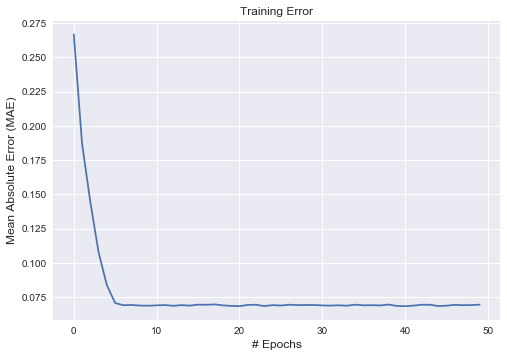

In [47]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(btc_history.epoch, btc_history.history['loss'])
ax1.set_title('Training Error')

if btc_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

### Training Set Performance

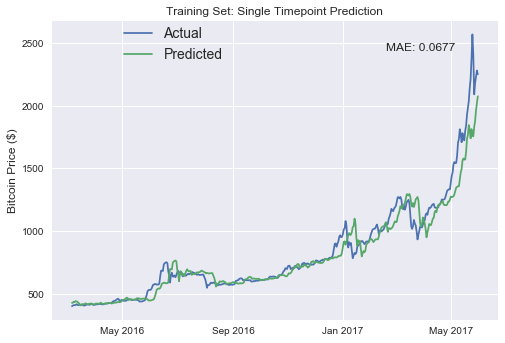

In [48]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(newdf[newdf['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         training_set['price'][window_len:], label='Actual')
ax1.plot(newdf[newdf['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(btc_model.predict(LSTM_training_inputs))+1) * training_set['price'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(btc_model.predict(LSTM_training_inputs))+1)-\
            (training_set['price'].values[window_len:])/(training_set['price'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
# axins = zoomed_inset_axes(ax1, 3.35, loc=10) # zoom-factor: 3.35, location: centre
# axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
# axins.plot(newdf[newdf['date']< split_date]['date'][window_len:].astype(datetime.datetime),
#         training_set['price'][window_len:], label='Actual')
# axins.plot(newdf[newdf['date']< split_date]['date'][window_len:].astype(datetime.datetime),
#         ((np.transpose(btc_model.predict(LSTM_training_inputs))+1) * training_set['price'].values[:-window_len])[0], 
#         label='Predicted')
# axins.set_xlim([datetime.date(2017, 3, 1), datetime.date(2017, 5, 1)])
# axins.set_ylim([10,60])
# axins.set_xticklabels('')
# mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

### Test set performance
Perhaps not a surprise, but the model didn't do well during the big run-up last year. Although there seems to be something wrong with the coding on this plot.

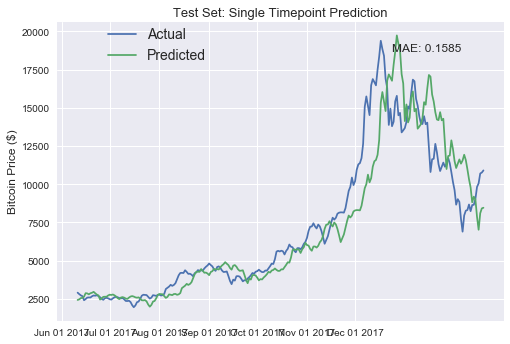

In [49]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(newdf[newdf['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         test_set['price'][window_len:], label='Actual')
ax1.plot(newdf[newdf['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(btc_model.predict(LSTM_test_inputs))+1) * test_set['price'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(btc_model.predict(LSTM_test_inputs))+1)-\
            (test_set['price'].values[window_len:])/(test_set['price'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()